<a href="https://colab.research.google.com/github/ananyas168/GNN/blob/main/entity_alingment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
torch.__version__

'1.9.0+cu102'

In [ ]:
!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install torch-geometric
!pip install torch-geometric-temporalv

Looking in links: https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
     |████████████████████████████████| 3.0 MB 2.6 MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
     |████████████████████████████████| 1.6 MB 2.1 MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
     |████████████████████████████████| 926 kB 2.1 MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
     |████████████████████████████████| 382 kB 2.1 MB/s 
     |████████████████████████████████| 222 kB 5.0 MB/s 
     |████████████████████████████████| 376 kB 49.7 MB/s 
     |████████████████████████████████| 45 kB 3.3 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-1.7.2-py3-none-any.whl size=388143 sha256=8bb5b7f5ae4153ad19792182997b633f62c4e7e8ff4d668382fd802fce4caf09
  Stored in directory: /root/.cache/pip/wheels/55/93/b6/2eeb0465afe89aee74d7a07a606e9770466d7565abd45a99d5
Successfully built torch-

**About the DATASET:**
The DBP15K dataset from the
    `"Cross-lingual Entity Alignment via Joint Attribute-Preserving Embedding"
    <https://arxiv.org/abs/1708.05045>`_ paper, where Chinese, Japanese and
    French versions of DBpedia were linked to its English version.
    Node features are given by pre-trained and aligned monolingual word
    embeddings from the `"Cross-lingual Knowledge Graph Alignment via Graph
    Matching Neural Network" <https://arxiv.org/abs/1905.11605>`_ paper.

In [ ]:
from torch_geometric.datasets import DBP15K
class SumEmbedding(object):
    def __call__(self, data):
        data.x1, data.x2 = data.x1.sum(dim=1), data.x2.sum(dim=1)
        return data


#device = 'cuda' if torch.cuda.is_available() else 'cpu'
# path = osp.join('..', 'data', 'DBP15K')
data_zh_en = DBP15K('/content/dd', 'zh_en', transform=SumEmbedding())[0]
print('data_zh_en',data_zh_en)
data_en_zh = DBP15K('/content/dd', 'en_zh', transform=SumEmbedding())[0]
print('data_en_zh',data_en_zh)
data_fr_en = DBP15K('/content/dd', 'fr_en', transform=SumEmbedding())[0]
print('data_fr_en',data_fr_en)
data_en_fr = DBP15K('/content/dd', 'en_fr', transform=SumEmbedding())[0]
print('data_en_fr',data_en_fr)
data_ja_en = DBP15K('/content/dd', 'ja_en', transform=SumEmbedding())[0]
print('data_ja_en',data_ja_en)
data_en_ja = DBP15K('/content/dd', 'en_ja', transform=SumEmbedding())[0]
print('data_en_ja',data_en_ja)

In [ ]:
data = data_en_zh 

In [ ]:
data.x1#,data.edge_index1

tensor([[-0.0331, -0.8537,  0.7676,  ..., -0.3320,  1.1998, -0.3019],
        [ 0.4849,  0.1848,  0.5640,  ...,  1.0869,  1.9791,  0.0196],
        [ 0.6291, -0.1322,  0.3547,  ...,  0.1585, -0.7663,  0.4406],
        ...,
        [-0.4501,  0.2176, -0.7980,  ..., -0.4169,  0.5151, -0.4726],
        [ 1.1127,  0.0317,  0.2945,  ...,  0.9860,  0.0831, -0.1849],
        [ 0.5596, -0.4150,  0.1231,  ..., -0.1048, -0.3590, -1.1552]])

In [ ]:
# l=data.train_y[0].tolist()
# print(len(l))
# one = torch.zeros(l[-1]+1)
# print(one.shape)
# for i in range(len(l)):
#   if (i> len(l) -1):
#     break
#   one[l[i]] = 1
# print(one) 

In [ ]:
# k=data.test_y[0].tolist()
# print(sorted(k))
# print(k[8777])
# k = sorted(k)
# print(len(sorted(k)))
# truth_y = torch.zeros(k[-1]+1)
# print(truth_y.shape)
# for i in range(len(k)):
#   # if (i> len(k) -1):
#   #   break
#   truth_y[k[i]] = 1
# #truth_y= truth_y[4500:]  
# print(truth_y)
# m= k[-1] - l[-1]
# print('m',m)
# start_val = l[-1]+1 
# end_val = int(m*0.5-1)
# start_test = int(m*0.5)
# print('end_val',end_val)
# end_test = k[-1]+1
# print(start_val)
# truth_val_y = truth_y[start_val:end_val] 
# truth_test_y = truth_y[m:end_test]    

In [ ]:
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
import torch.nn.functional as F
from torch_geometric.nn import Sequential, GCNConv,SAGEConv,RGCNConv,GATConv
from torch.nn import Conv1d, Linear

In [ ]:
def model_summary(model):
  print("model_summary")
  print()
  print("Layer_name"+"\t"*7+"Number of Parameters")
  print("="*100)
  model_parameters = [layer for layer in model.parameters() if layer.requires_grad]
  layer_name = [child for child in model.children()]
  j = 0
  total_params = 0
  print("\t"*10)
  for i in layer_name:
    print()
    param = 0
    try:
      bias = (i.bias is not None)
    except:
      bias = False  
    if not bias:
      param =model_parameters[j].numel()+model_parameters[j+1].numel()
      j = j+2
    else:
      param =model_parameters[j].numel()
      j = j+1
    print(str(i)+"\t"*3+str(param))
    total_params+=param
  print("="*100)
  print(f"Total Params:{total_params}")       

#model_summary(net)

#print(model_summary(model_NN))

# MLP model

In [ ]:
class NN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        features_dim = data.x1.shape[1] #300
        self.conv1 = Linear(features_dim,150)
        self.conv2 = Linear(150, 7)  # 7 is our D here feature vector dimention
        #self.linear = torch.nn.Linear(7,1)

    def forward(self, featss):
       
        x = featss
         
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        # x = F.relu(x)
        # x = self.Linear(x)
        # x = F.relu(x)

        return x

#CNN MODEL

In [ ]:
class CNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        features_dim = data.x1.shape[1] #300
        self.conv1 = Conv1d(1, 1,3,stride=1)
        self.conv2 = Conv1d(1, 1,3,stride =1)  # 7 is our D here feature vector dimention
        #self.linear = torch.nn.Linear(7,1)

    def forward(self, featss):
       
        x = featss
         
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
     

        return x

#GCN model

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        features_dim = data.x1.shape[1] #300
        self.conv1 = GCNConv(features_dim, 150)
        self.conv2 = GCNConv(150, 7)  # 7 is our D here feature vector dimention
        #self.linear = torch.nn.Linear(7,1)

    def forward(self, featss,index):
       
        x, edge_index = featss, index
         
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
      

        return x


# GRAPH SAGE model

In [ ]:
class Gsage(torch.nn.Module):
    def __init__(self):
        super().__init__()
        features_dim = data.x1.shape[1]
        self.conv1 = SAGEConv(features_dim, 150)
        self.conv2 = SAGEConv(150, 7)  # 7 is our D here feature vector dimention
        #self.linear = torch.nn.Linear(7,1)

    def forward(self, featss,index):
       
        x, edge_index = featss, index
         
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
     
        return x

#GAT MODEL

In [ ]:
class GAT(torch.nn.Module):
    def __init__(self):
        super().__init__()
        features_dim = data.x1.shape[1]
        self.conv1 = GATConv(features_dim, 150)
        self.conv2 = GATConv(150, 7)  # 7 is our D here feature vector dimention
        #self.linear = torch.nn.Linear(7,1)

    def forward(self, featss,index):
       
        x, edge_index = featss, index
         
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)


        return x


#training module

In [ ]:
from sklearn.metrics import roc_auc_score, f1_score,accuracy_score
#model = GCN()
#model = Gsage()
def nn_train(data , model):
    criterion= torch.nn.BCEWithLogitsLoss()
    #train(data, model1, model2):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    best_test_acc=0
    l=data.train_y[0].tolist()
    #print(len(l))
    one = torch.zeros(l[-1]+1)
    #print(one.shape)
    for i in range(len(l)):
      if (i> len(l) -1):
        break
      one[l[i]] = 1
    print(one.shape) 
    end_train = l[-1]+1
    k=data.test_y[0].tolist()
    #print(sorted(k))
    #print(k[8777])
    k = sorted(k)
    #print(len(sorted(k)))
    truth_y = torch.zeros(k[-1]+1)
    #print(truth_y.shape)
    for i in range(len(k)):
      # if (i> len(k) -1):
      #   break
      truth_y[k[i]] = 1
    #truth_y= truth_y[4500:]  
    #print(truth_y)
    m= k[-1] - l[-1]
    #print('m',m)
    start_val = l[-1]+1 
    end_val = int(m*0.5-1)+4500
    #print('end_val',end_val)
    start_test = end_val+1
    end_test = k[-1]+1
    #print(start_val)
    truth_val_y = truth_y[start_val:end_val] 
    truth_test_y = truth_y[start_test:end_test]
    print('truth_val_y',truth_val_y.shape)
    print('truth_test_y',truth_test_y.shape)
    print('start_val',start_val)
    print('end_val',end_val)
    print('start_test',start_test)
    print('end_test',end_test)

    for e in range(70):
      #dataset 
      # train_loader = DataLoader(dataset, batch_size=32, shuffle=True)
      # for batch in train_loader
       
      out1 = model(data.x1)
      #print('out1:',out1.shape)
      out2 = model(data.x2)
      #print('out2:',out2.shape)
      #pdist = torch.nn.PairwiseDistance(p=2)
      pdist = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
      output = pdist(out1[:end_train], out2[:end_train])
      #print('output:', output.shape)
      #output = F.sigmoid(output)
      loss = criterion(output , one)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      
      


      #train accuracy calculation
      train_output= output
      train_output[train_output>0]= 1
      train_output[train_output<0]= 0
      train_accuracy = accuracy_score(one.detach().numpy(),train_output.detach().numpy())
      #print("accuracy",accuracy)
      val_output = pdist(out1[start_val:end_val], out2[start_val:end_val]) 
      val_output[val_output>0]= 1
      val_output[val_output<0]= 0
      val_accuracy = accuracy_score(truth_val_y.detach().numpy(),val_output.detach().numpy())
      #print("accuracy",accuracy)
      if e % 5 == 0:
        print('In epoch {}, loss: {},  train_accuracy: {}, val_accuracy: {}'.format(e, loss,train_accuracy,val_accuracy ))

      # if e % 5 == 0:
      #   print('In epoch {}, loss: {},  train_accuracy: {}'.format(e, loss,train_accuracy ))

    print("-"*50)
    #test accuracy, auc, f1 score calculation
    pdist = torch.nn.CosineSimilarity(dim=1, eps=1e-6)

    test_output = pdist(out1[start_test:end_test], out2[start_test:end_test])
    print('test_output shape',test_output.shape) 
    auc_score = roc_auc_score(truth_test_y.detach().numpy(),test_output.detach().numpy())
    print("test_auc_score",auc_score)
    test_output[test_output>0]= 1
    test_output[test_output<0]= 0
    accuracy = accuracy_score(truth_test_y.detach().numpy(),test_output.detach().numpy())
    print("test_accuracy",accuracy)
    f1_score_value = f1_score(truth_test_y.detach().numpy(),test_output.detach().numpy())
    print("test_f1_score",f1_score_value)

# model =NN()
# nn_train(data,model) 


In [ ]:
from sklearn.metrics import roc_auc_score, f1_score,accuracy_score

def cnn_train(data , model,epoch):
    criterion= torch.nn.BCEWithLogitsLoss()
    #train(data, model1, model2):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    best_test_acc=0
    l=data.train_y[0].tolist()
    #print(len(l))
    one = torch.zeros(l[-1]+1)
    #print(one.shape)
    for i in range(len(l)):
      if (i> len(l) -1):
        break
      one[l[i]] = 1
    print(one.shape) 
    end_train = l[-1]+1
    k=data.test_y[0].tolist()
    #print(sorted(k))
    #print(k[8777])
    k = sorted(k)
    #print(len(sorted(k)))
    truth_y = torch.zeros(k[-1]+1)
    #print(truth_y.shape)
    for i in range(len(k)):
      # if (i> len(k) -1):
      #   break
      truth_y[k[i]] = 1
    #truth_y= truth_y[4500:]  
    #print(truth_y)
    m= k[-1] - l[-1]
    #print('m',m)
    start_val = l[-1]+1 
    end_val = int(m*0.5-1)+4500
    #print('end_val',end_val)
    start_test = end_val+1
    end_test = k[-1]+1
    #print(start_val)
    truth_val_y = truth_y[start_val:end_val] 
    truth_test_y = truth_y[start_test:end_test]
    print('truth_val_y',truth_val_y.shape)
    print('truth_test_y',truth_test_y.shape)
    print('start_val',start_val)
    print('end_val',end_val)
    print('start_test',start_test)
    print('end_test',end_test)
    for e in range(epoch):
      #dataset 
      # train_loader = DataLoader(dataset, batch_size=32, shuffle=True)
      # for batch in train_loader
       
      out1 = model(data.x1.unsqueeze(1))
      #print('out1:',out1.shape)
      out2 = model(data.x2.unsqueeze(1))
      #print('out2:',out2.shape)
      #pdist = torch.nn.PairwiseDistance(p=2)
      pdist = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
      output = pdist(out1.squeeze(1)[:end_train], out2.squeeze(1)[:end_train])
      #print('output:', output.shape)
      #output = F.sigmoid(output)
      loss = criterion(output , one)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      
      


      #train accuracy calculation
      train_output= output
      train_output[train_output>0]= 1
      train_output[train_output<0]= 0
      train_accuracy = accuracy_score(one.detach().numpy(),train_output.detach().numpy())
      #print("accuracy",accuracy)
      val_output = pdist(out1.squeeze(1)[start_val:end_val], out2.squeeze(1)[start_val:end_val]) 
      val_output[val_output>0]= 1
      val_output[val_output<0]= 0
      val_accuracy = accuracy_score(truth_val_y.detach().numpy(),val_output.detach().numpy())
      #print("accuracy",accuracy)
      if e % 5 == 0:
        print('In epoch {}, loss: {},  train_accuracy: {}, val_accuracy: {}'.format(e, loss,train_accuracy,val_accuracy ))

      # if e % 5 == 0:
      #   print('In epoch {}, loss: {},  train_accuracy: {}'.format(e, loss,train_accuracy ))

    print("-"*50)
    #test accuracy, auc, f1 score calculation
    pdist = torch.nn.CosineSimilarity(dim=1, eps=1e-6)

    test_output = pdist(out1.squeeze(1)[start_test:end_test], out2.squeeze(1)[start_test:end_test])
    #print('test_output shape',test_output.shape) 
    auc_score = roc_auc_score(truth_test_y.detach().numpy(),test_output.detach().numpy())
    print("test_auc_score",auc_score)
    test_output[test_output>0]= 1
    test_output[test_output<0]= 0
    accuracy = accuracy_score(truth_test_y.detach().numpy(),test_output.detach().numpy())
    print("test_accuracy",accuracy)
    f1_score_value = f1_score(truth_test_y.detach().numpy(),test_output.detach().numpy())
    print("test_f1_score",f1_score_value)

# model =CNN()
# cnn_train(data,model) 


In [ ]:
from sklearn.metrics import roc_auc_score, f1_score,accuracy_score
#model = GCN()
#model = Gsage()
def train(data , model, epoch):
    criterion= torch.nn.BCEWithLogitsLoss()
    #train(data, model1, model2):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    best_test_acc=0

    #truth values:
    l=data.train_y[0].tolist()
    #print(len(l))
    one = torch.zeros(l[-1]+1)
    #print(one.shape)
    for i in range(len(l)):
      if (i> len(l) -1):
        break
      one[l[i]] = 1
    print(one.shape) 
    end_train = l[-1]+1
    k=data.test_y[0].tolist()
    #print(sorted(k))
    #print(k[8777])
    k = sorted(k)
    #print(len(sorted(k)))
    truth_y = torch.zeros(k[-1]+1)
    #print(truth_y.shape)
    for i in range(len(k)):
      # if (i> len(k) -1):
      #   break
      truth_y[k[i]] = 1
    #truth_y= truth_y[4500:]  
    #print(truth_y)
    m= k[-1] - l[-1]
    #print('m',m)
    start_val = l[-1]+1 
    end_val = int(m*0.5-1)+4500
    #print('end_val',end_val)
    start_test = end_val+1
    end_test = k[-1]+1
    #print(start_val)
    truth_val_y = truth_y[start_val:end_val] 
    truth_test_y = truth_y[start_test:end_test]
    print('truth_val_y',truth_val_y.shape)
    print('truth_test_y',truth_test_y.shape)
    print('start_val',start_val)
    print('end_val',end_val)
    print('start_test',start_test)
    print('end_test',end_test)
    for e in range(epoch):
      #dataset 
      # train_loader = DataLoader(dataset, batch_size=32, shuffle=True)
      # for batch in train_loader
        
      out1 = model(data.x1, data.edge_index1)
      #print('out1:',out1.shape)
      out2 = model(data.x2, data.edge_index2)
      #print('out2:',out2.shape)
      #pdist = torch.nn.PairwiseDistance(p=2)
      pdist = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
      output = pdist(out1[:end_train], out2[:end_train])
      #print('output:', output.shape)
      #output = F.sigmoid(output)
      loss = criterion(output , one)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      
      


      #train accuracy calculation
      train_output= output
      train_output[train_output>0]= 1
      train_output[train_output<0]= 0
      train_accuracy = accuracy_score(one.detach().numpy(),train_output.detach().numpy())
      val_output = pdist(out1[start_val:end_val], out2[start_val:end_val]) 
      val_output[val_output>0]= 1
      val_output[val_output<0]= 0
      val_accuracy = accuracy_score(truth_val_y.detach().numpy(),val_output.detach().numpy())
      #print("accuracy",accuracy)
      if e % 5 == 0:
        print('In epoch {}, loss: {},  train_accuracy: {}, val_accuracy: {}'.format(e, loss,train_accuracy,val_accuracy ))

    print("-"*50)
    #test accuracy, auc, f1 score calculation
    pdist = torch.nn.CosineSimilarity(dim=1, eps=1e-6)

    test_output = pdist(out1[start_test:end_test], out2[start_test:end_test]) 
    auc_score = roc_auc_score(truth_test_y.detach().numpy(),test_output.detach().numpy())
    print("test_auc_score",auc_score)
    test_output[test_output>0]= 1
    test_output[test_output<0]= 0
    accuracy = accuracy_score(truth_test_y.detach().numpy(),test_output.detach().numpy())
    print("test_accuracy",accuracy)
    f1_score_value = f1_score(truth_test_y.detach().numpy(),test_output.detach().numpy())
    print("test_f1_score",f1_score_value)

  


#results and outputs for zh_en

In [ ]:
print('MODEL: MLP')
model_NN =NN()
nn_train(data_zh_en,model_NN)

MODEL: MLP
torch.Size([4500])
truth_val_y torch.Size([5249])
truth_test_y torch.Size([5250])
start_val 4500
end_val 9749
start_test 9750
end_test 15000
In epoch 0, loss: 0.5396087169647217,  train_accuracy: 0.7242222222222222, val_accuracy: 0.8447323299676128
In epoch 5, loss: 0.5090281367301941,  train_accuracy: 0.7835555555555556, val_accuracy: 0.8725471518384454
In epoch 10, loss: 0.4659934341907501,  train_accuracy: 0.8433333333333334, val_accuracy: 0.8670222899599924
In epoch 15, loss: 0.4485625922679901,  train_accuracy: 0.8646666666666667, val_accuracy: 0.8698799771385026
In epoch 20, loss: 0.4289475679397583,  train_accuracy: 0.8875555555555555, val_accuracy: 0.8731186892741475
In epoch 25, loss: 0.4096686840057373,  train_accuracy: 0.9175555555555556, val_accuracy: 0.866831777481425
In epoch 30, loss: 0.3895737826824188,  train_accuracy: 0.9368888888888889, val_accuracy: 0.8647361402171843
In epoch 35, loss: 0.374740332365036,  train_accuracy: 0.952, val_accuracy: 0.8632120403

In [ ]:
print(model_summary(model_NN))

model_summary

Layer_name							Number of Parameters
										

Linear(in_features=300, out_features=150, bias=True)			45000

Linear(in_features=150, out_features=7, bias=True)			150
Total Params:45150
None


In [ ]:
print('MODEL: CNN')
model_CNN =CNN()
cnn_train(data_zh_en,model_CNN,30)

MODEL: CNN
torch.Size([4500])
truth_val_y torch.Size([5249])
truth_test_y torch.Size([5250])
start_val 4500
end_val 9749
start_test 9750
end_test 15000
In epoch 0, loss: 0.6006363034248352,  train_accuracy: 0.7122222222222222, val_accuracy: 0.8367308058677844
In epoch 5, loss: 0.5974547266960144,  train_accuracy: 0.7122222222222222, val_accuracy: 0.8367308058677844
In epoch 10, loss: 0.5849257707595825,  train_accuracy: 0.7122222222222222, val_accuracy: 0.8367308058677844
In epoch 15, loss: 0.5546330809593201,  train_accuracy: 0.7122222222222222, val_accuracy: 0.8367308058677844
In epoch 20, loss: 0.5158621668815613,  train_accuracy: 0.7133333333333334, val_accuracy: 0.8382549056963231
In epoch 25, loss: 0.5015417337417603,  train_accuracy: 0.7357777777777778, val_accuracy: 0.8594017908172985
--------------------------------------------------
test_auc_score 0.9791361775891274
test_accuracy 0.8436190476190476
test_f1_score 0.9143810616331213


In [ ]:
print(model_summary(model_CNN))

model_summary

Layer_name							Number of Parameters
										

Conv1d(1, 1, kernel_size=(3,), stride=(1,))			3

Conv1d(1, 1, kernel_size=(3,), stride=(1,))			1
Total Params:4
None


In [ ]:
print('MODEL: GRAPH CONV(GCN)')
model_GCN= GCN()
print(model_summary(model_GCN))
train(data_zh_en,model_GCN, 14)

MODEL: GRAPH CONV(GCN)
model_summary

Layer_name							Number of Parameters
										

GCNConv(300, 150)			45000

GCNConv(150, 7)			150
Total Params:45150
None
torch.Size([4500])
truth_val_y torch.Size([5249])
truth_test_y torch.Size([5250])
start_val 4500
end_val 9749
start_test 9750
end_test 15000
In epoch 0, loss: 0.5793065428733826,  train_accuracy: 0.7166666666666667, val_accuracy: 0.8367308058677844
In epoch 5, loss: 0.5385364294052124,  train_accuracy: 0.7655555555555555, val_accuracy: 0.8344446561249762
In epoch 10, loss: 0.5087810158729553,  train_accuracy: 0.8042222222222222, val_accuracy: 0.8264431320251476
--------------------------------------------------
test_auc_score 0.7668445370120155
test_accuracy 0.8232380952380952
test_f1_score 0.8955895589558955


In [ ]:
print('MODEL:GRAPH SAGE')
model_Gsage= Gsage()
print(model_summary(model_Gsage))
train(data_zh_en,model_Gsage, 20)

MODEL:GRAPH SAGE
model_summary

Layer_name							Number of Parameters
										

SAGEConv(300, 150)			45150

SAGEConv(150, 7)			46050
Total Params:91200
None
torch.Size([4500])
truth_val_y torch.Size([5249])
truth_test_y torch.Size([5250])
start_val 4500
end_val 9749
start_test 9750
end_test 15000
In epoch 0, loss: 0.5691213607788086,  train_accuracy: 0.7195555555555555, val_accuracy: 0.8380643932177557
In epoch 5, loss: 0.4773496091365814,  train_accuracy: 0.8322222222222222, val_accuracy: 0.8729281767955801
In epoch 10, loss: 0.4358249306678772,  train_accuracy: 0.8855555555555555, val_accuracy: 0.8683558773099638
In epoch 15, loss: 0.4035932421684265,  train_accuracy: 0.9262222222222222, val_accuracy: 0.8614974280815394
--------------------------------------------------
test_auc_score 0.8976908931525629
test_accuracy 0.8664761904761905
test_f1_score 0.9188563491144809


In [ ]:
print('MODEL:  GAT')
model_GAT= GAT()
print(model_summary(model_GAT))
train(data_zh_en,model_GAT,20)

MODEL:  GAT
model_summary

Layer_name							Number of Parameters
										

GATConv(300, 150, heads=1)			150

GATConv(150, 7, heads=1)			150
Total Params:300
None
torch.Size([4500])
truth_val_y torch.Size([5249])
truth_test_y torch.Size([5250])
start_val 4500
end_val 9749
start_test 9750
end_test 15000
In epoch 0, loss: 0.5814074277877808,  train_accuracy: 0.7162222222222222, val_accuracy: 0.8376833682606211
In epoch 5, loss: 0.5140196681022644,  train_accuracy: 0.7948888888888889, val_accuracy: 0.8325395313393027
In epoch 10, loss: 0.47523295879364014,  train_accuracy: 0.8557777777777777, val_accuracy: 0.8209182701466946
In epoch 15, loss: 0.44787320494651794,  train_accuracy: 0.8966666666666666, val_accuracy: 0.8035816345970661
--------------------------------------------------
test_auc_score 0.7538410635310866
test_accuracy 0.7975238095238095
test_f1_score 0.878722190530519




---

                                        END

---





#results and outputs for en_zh

In [ ]:
print('MODEL: MLP')
model_NN =NN()
nn_train(data_en_zh,model_NN)

MODEL: MLP
torch.Size([4500])
truth_val_y torch.Size([5249])
truth_test_y torch.Size([5250])
start_val 4500
end_val 9749
start_test 9750
end_test 15000
In epoch 0, loss: 0.5364522933959961,  train_accuracy: 0.7302222222222222, val_accuracy: 0.8750238140598209
In epoch 5, loss: 0.476596474647522,  train_accuracy: 0.8255555555555556, val_accuracy: 0.8674033149171271
In epoch 10, loss: 0.452379047870636,  train_accuracy: 0.8617777777777778, val_accuracy: 0.866260240045723
In epoch 15, loss: 0.4288860559463501,  train_accuracy: 0.8902222222222222, val_accuracy: 0.8611164031244046
In epoch 20, loss: 0.40628454089164734,  train_accuracy: 0.9202222222222223, val_accuracy: 0.8555915412459516
In epoch 25, loss: 0.3833748400211334,  train_accuracy: 0.9504444444444444, val_accuracy: 0.8523528291103067
In epoch 30, loss: 0.36827531456947327,  train_accuracy: 0.9644444444444444, val_accuracy: 0.8479710421032578
In epoch 35, loss: 0.35024842619895935,  train_accuracy: 0.9784444444444444, val_accurac

In [ ]:
print('MODEL: CNN')
model_CNN =CNN()
cnn_train(data_en_zh,model_CNN,40)

MODEL: CNN
torch.Size([4500])
truth_val_y torch.Size([5249])
truth_test_y torch.Size([5250])
start_val 4500
end_val 9749
start_test 9750
end_test 15000
In epoch 0, loss: 0.5817025899887085,  train_accuracy: 0.7206666666666667, val_accuracy: 0.8693084397028006
In epoch 5, loss: 0.5515751242637634,  train_accuracy: 0.7211111111111111, val_accuracy: 0.8694989521813679
In epoch 10, loss: 0.5059163570404053,  train_accuracy: 0.7386666666666667, val_accuracy: 0.8851209754238902
In epoch 15, loss: 0.5001211166381836,  train_accuracy: 0.7466666666666667, val_accuracy: 0.8942655743951229
In epoch 20, loss: 0.5053857564926147,  train_accuracy: 0.7406666666666667, val_accuracy: 0.8853114879024576
In epoch 25, loss: 0.5021609663963318,  train_accuracy: 0.744, val_accuracy: 0.8902648123452086
In epoch 30, loss: 0.4980672597885132,  train_accuracy: 0.7502222222222222, val_accuracy: 0.9007429986664126
In epoch 35, loss: 0.49801236391067505,  train_accuracy: 0.7506666666666667, val_accuracy: 0.8995999

In [ ]:
print('MODEL: GRAPH CONV(GCN)')
model_GCN= GCN()
train(data_en_zh,model_GCN, 14)

MODEL: GRAPH CONV(GCN)
torch.Size([4500])
truth_val_y torch.Size([5249])
truth_test_y torch.Size([5250])
start_val 4500
end_val 9749
start_test 9750
end_test 15000
In epoch 0, loss: 0.5716574788093567,  train_accuracy: 0.73, val_accuracy: 0.8670222899599924
In epoch 5, loss: 0.5240843296051025,  train_accuracy: 0.7844444444444445, val_accuracy: 0.8601638407315679
In epoch 10, loss: 0.4922056198120117,  train_accuracy: 0.8322222222222222, val_accuracy: 0.841493617831968
--------------------------------------------------
test_auc_score 0.7517172115829449
test_accuracy 0.8331428571428572
test_f1_score 0.9043041293423639


In [ ]:
print('MODEL:GRAPH SAGE')
model_Gsage= Gsage()
train(data_en_zh,model_Gsage, 20)

MODEL:GRAPH SAGE
torch.Size([4500])
truth_val_y torch.Size([5249])
truth_test_y torch.Size([5250])
start_val 4500
end_val 9749
start_test 9750
end_test 15000
In epoch 0, loss: 0.570249617099762,  train_accuracy: 0.7275555555555555, val_accuracy: 0.866260240045723
In epoch 5, loss: 0.4790484607219696,  train_accuracy: 0.8251111111111111, val_accuracy: 0.8590207658601638
In epoch 10, loss: 0.4289983808994293,  train_accuracy: 0.894, val_accuracy: 0.850828729281768
In epoch 15, loss: 0.3976283073425293,  train_accuracy: 0.9344444444444444, val_accuracy: 0.8460659173175843
--------------------------------------------------
test_auc_score 0.8563178096012253
test_accuracy 0.8476190476190476
test_f1_score 0.9105345560277344


In [ ]:
print('MODEL:  GAT')
model_GAT= GAT()
train(data_en_zh,model_GAT,20)

MODEL:  GAT
torch.Size([4500])
truth_val_y torch.Size([5249])
truth_test_y torch.Size([5250])
start_val 4500
end_val 9749
start_test 9750
end_test 15000
In epoch 0, loss: 0.5721561908721924,  train_accuracy: 0.7328888888888889, val_accuracy: 0.8632120403886454
In epoch 5, loss: 0.5109281539916992,  train_accuracy: 0.8013333333333333, val_accuracy: 0.8462564297961517
In epoch 10, loss: 0.472844660282135,  train_accuracy: 0.8602222222222222, val_accuracy: 0.8374928557820537
In epoch 15, loss: 0.44848209619522095,  train_accuracy: 0.8922222222222222, val_accuracy: 0.8239664698037722
--------------------------------------------------
test_auc_score 0.7373010961925995
test_accuracy 0.8243809523809524
test_f1_score 0.8986590459441636




---

                                        END

---





#results and outputs for fr_en

In [ ]:
print('MODEL: MLP')
model_NN =NN()
nn_train(data_fr_en,model_NN)

MODEL: MLP
torch.Size([4500])
truth_val_y torch.Size([5249])
truth_test_y torch.Size([5250])
start_val 4500
end_val 9749
start_test 9750
end_test 15000
In epoch 0, loss: 0.3889726400375366,  train_accuracy: 0.9157777777777778, val_accuracy: 0.9626595542008002
In epoch 5, loss: 0.3519088923931122,  train_accuracy: 0.9655555555555555, val_accuracy: 0.9527529053152981
In epoch 10, loss: 0.33928239345550537,  train_accuracy: 0.98, val_accuracy: 0.951038293008192
In epoch 15, loss: 0.33017244935035706,  train_accuracy: 0.9882222222222222, val_accuracy: 0.9506572680510573
In epoch 20, loss: 0.32573723793029785,  train_accuracy: 0.9931111111111111, val_accuracy: 0.9458944560868737
In epoch 25, loss: 0.3210880756378174,  train_accuracy: 0.9953333333333333, val_accuracy: 0.9443703562583349
In epoch 30, loss: 0.31869515776634216,  train_accuracy: 0.9966666666666667, val_accuracy: 0.9422747189940941
In epoch 35, loss: 0.3209429383277893,  train_accuracy: 0.9957777777777778, val_accuracy: 0.939036

In [ ]:
print('MODEL: CNN')
model_CNN =CNN()
cnn_train(data_fr_en,model_CNN,50)

MODEL: CNN
torch.Size([4500])
truth_val_y torch.Size([5249])
truth_test_y torch.Size([5250])
start_val 4500
end_val 9749
start_test 9750
end_test 15000
In epoch 0, loss: 0.38616254925727844,  train_accuracy: 0.9157777777777778, val_accuracy: 0.9620880167650981
In epoch 5, loss: 0.38339850306510925,  train_accuracy: 0.9173333333333333, val_accuracy: 0.9626595542008002
In epoch 10, loss: 0.38310617208480835,  train_accuracy: 0.9173333333333333, val_accuracy: 0.9630405791579348
In epoch 15, loss: 0.3829772174358368,  train_accuracy: 0.9171111111111111, val_accuracy: 0.9634216041150695
In epoch 20, loss: 0.3826475441455841,  train_accuracy: 0.9175555555555556, val_accuracy: 0.9651362164221756
In epoch 25, loss: 0.3827027380466461,  train_accuracy: 0.9173333333333333, val_accuracy: 0.9645646789864736
In epoch 30, loss: 0.38257721066474915,  train_accuracy: 0.9175555555555556, val_accuracy: 0.9657077538578777
In epoch 35, loss: 0.3825676143169403,  train_accuracy: 0.9175555555555556, val_acc

In [ ]:
print('MODEL: GRAPH CONV(GCN)')
model_GCN= GCN()
train(data_fr_en,model_GCN, 14)

MODEL: GRAPH CONV(GCN)
torch.Size([4500])
truth_val_y torch.Size([5249])
truth_test_y torch.Size([5250])
start_val 4500
end_val 9749
start_test 9750
end_test 15000
In epoch 0, loss: 0.4136854112148285,  train_accuracy: 0.9144444444444444, val_accuracy: 0.95980186702229
In epoch 5, loss: 0.3967994749546051,  train_accuracy: 0.9162222222222223, val_accuracy: 0.9620880167650981
In epoch 10, loss: 0.39657825231552124,  train_accuracy: 0.916, val_accuracy: 0.9613259668508287
--------------------------------------------------
test_auc_score 0.7116771972198032
test_accuracy 0.9657142857142857
test_f1_score 0.9825547586741616


In [ ]:
print('MODEL:GRAPH SAGE')
model_Gsage= Gsage()
train(data_fr_en,model_Gsage, 20)

MODEL:GRAPH SAGE
torch.Size([4500])
truth_val_y torch.Size([5249])
truth_test_y torch.Size([5250])
start_val 4500
end_val 9749
start_test 9750
end_test 15000
In epoch 0, loss: 0.4308221638202667,  train_accuracy: 0.902, val_accuracy: 0.9506572680510573
In epoch 5, loss: 0.3967096209526062,  train_accuracy: 0.9157777777777778, val_accuracy: 0.9620880167650981
In epoch 10, loss: 0.3956536650657654,  train_accuracy: 0.9157777777777778, val_accuracy: 0.9620880167650981
In epoch 15, loss: 0.39371320605278015,  train_accuracy: 0.9191111111111111, val_accuracy: 0.9615164793293961
--------------------------------------------------
test_auc_score 0.8502821287230692
test_accuracy 0.9638095238095238
test_f1_score 0.9815677143965852


In [ ]:
print('MODEL:  GAT')
model_GAT= GAT()
train(data_fr_en,model_GAT,20)

MODEL:  GAT
torch.Size([4500])
truth_val_y torch.Size([5249])
truth_test_y torch.Size([5250])
start_val 4500
end_val 9749
start_test 9750
end_test 15000
In epoch 0, loss: 0.42628124356269836,  train_accuracy: 0.91, val_accuracy: 0.955420080015241
In epoch 5, loss: 0.39698633551597595,  train_accuracy: 0.916, val_accuracy: 0.9620880167650981
In epoch 10, loss: 0.3967367112636566,  train_accuracy: 0.9166666666666666, val_accuracy: 0.9620880167650981
In epoch 15, loss: 0.3965286314487457,  train_accuracy: 0.9168888888888889, val_accuracy: 0.9620880167650981
--------------------------------------------------
test_auc_score 0.730452354197162
test_accuracy 0.9655238095238096
test_f1_score 0.9824595406531641




---

                                        END

---





#results and outputs for en_fr

In [ ]:
print('MODEL: MLP')
model_NN =NN()
nn_train(data_en_fr,model_NN)

MODEL: MLP
torch.Size([4499])
truth_val_y torch.Size([5250])
truth_test_y torch.Size([5250])
start_val 4499
end_val 9749
start_test 9750
end_test 15000
In epoch 0, loss: 0.3902411162853241,  train_accuracy: 0.9133140697932874, val_accuracy: 0.9672380952380952
In epoch 5, loss: 0.36408182978630066,  train_accuracy: 0.9515447877306068, val_accuracy: 0.9603809523809523
In epoch 10, loss: 0.3454829752445221,  train_accuracy: 0.975994665481218, val_accuracy: 0.9516190476190476
In epoch 15, loss: 0.33298295736312866,  train_accuracy: 0.988664147588353, val_accuracy: 0.9457142857142857
In epoch 20, loss: 0.3269485831260681,  train_accuracy: 0.9924427650589019, val_accuracy: 0.9396190476190476
In epoch 25, loss: 0.32156381011009216,  train_accuracy: 0.9959991109135363, val_accuracy: 0.9379047619047619
In epoch 30, loss: 0.3187147378921509,  train_accuracy: 0.9975550122249389, val_accuracy: 0.9331428571428572
In epoch 35, loss: 0.31640875339508057,  train_accuracy: 0.9984440986885975, val_accur

In [ ]:
print('MODEL: CNN')
model_CNN =CNN()
cnn_train(data_en_fr,model_CNN,25)

MODEL: CNN
torch.Size([4499])
truth_val_y torch.Size([5250])
truth_test_y torch.Size([5250])
start_val 4499
end_val 9749
start_test 9750
end_test 15000
In epoch 0, loss: 0.4006741940975189,  train_accuracy: 0.910424538786397, val_accuracy: 0.9685714285714285
In epoch 5, loss: 0.3980441689491272,  train_accuracy: 0.910424538786397, val_accuracy: 0.9681904761904762
In epoch 10, loss: 0.3947865664958954,  train_accuracy: 0.9106468104023117, val_accuracy: 0.9683809523809523
In epoch 15, loss: 0.39190977811813354,  train_accuracy: 0.9137586130251167, val_accuracy: 0.9704761904761905
In epoch 20, loss: 0.38891884684562683,  train_accuracy: 0.9159813291842631, val_accuracy: 0.9737142857142858
--------------------------------------------------
test_auc_score 0.9856848903099178
test_accuracy 0.9767619047619047
test_f1_score 0.988164532402018


In [ ]:
print('MODEL: GRAPH CONV(GCN)')
model_GCN= GCN()
train(data_en_fr,model_GCN, 14)

MODEL: GRAPH CONV(GCN)
torch.Size([4499])
truth_val_y torch.Size([5250])
truth_test_y torch.Size([5250])
start_val 4499
end_val 9749
start_test 9750
end_test 15000
In epoch 0, loss: 0.44200068712234497,  train_accuracy: 0.8939764392087131, val_accuracy: 0.9432380952380952
In epoch 5, loss: 0.402349054813385,  train_accuracy: 0.9106468104023117, val_accuracy: 0.9685714285714285
In epoch 10, loss: 0.4019393026828766,  train_accuracy: 0.9106468104023117, val_accuracy: 0.9685714285714285
--------------------------------------------------
test_auc_score 0.6721447339263669
test_accuracy 0.9704761904761905
test_f1_score 0.9850169163847269


In [ ]:
print('MODEL:GRAPH SAGE')
model_Gsage= Gsage()
train(data_en_fr,model_Gsage, 20)

MODEL:GRAPH SAGE
torch.Size([4499])
truth_val_y torch.Size([5250])
truth_test_y torch.Size([5250])
start_val 4499
end_val 9749
start_test 9750
end_test 15000
In epoch 0, loss: 0.4302431643009186,  train_accuracy: 0.902200488997555, val_accuracy: 0.9580952380952381
In epoch 5, loss: 0.4015481770038605,  train_accuracy: 0.910424538786397, val_accuracy: 0.9685714285714285
In epoch 10, loss: 0.40044859051704407,  train_accuracy: 0.9108690820182263, val_accuracy: 0.9685714285714285
In epoch 15, loss: 0.3986078202724457,  train_accuracy: 0.9126472549455434, val_accuracy: 0.9681904761904762
--------------------------------------------------
test_auc_score 0.8429991452720884
test_accuracy 0.9700952380952381
test_f1_score 0.9848118409596595


In [ ]:
print('MODEL:  GAT')
model_GAT= GAT()
train(data_en_fr,model_GAT,20)

MODEL:  GAT
torch.Size([4499])
truth_val_y torch.Size([5250])
truth_test_y torch.Size([5250])
start_val 4499
end_val 9749
start_test 9750
end_test 15000
In epoch 0, loss: 0.4371315836906433,  train_accuracy: 0.9015336741498111, val_accuracy: 0.9561904761904761
In epoch 5, loss: 0.4020709693431854,  train_accuracy: 0.9113136252500555, val_accuracy: 0.9685714285714285
In epoch 10, loss: 0.40141913294792175,  train_accuracy: 0.9113136252500555, val_accuracy: 0.9685714285714285
In epoch 15, loss: 0.4007355868816376,  train_accuracy: 0.9126472549455434, val_accuracy: 0.9683809523809523
--------------------------------------------------
test_auc_score 0.691932634777929
test_accuracy 0.971047619047619
test_f1_score 0.9852998065764024




---

                                        END

---





#results and outputs for ja_en

In [ ]:
print('MODEL: MLP')
model_NN =NN()
nn_train(data_ja_en,model_NN)

MODEL: MLP
torch.Size([4500])
truth_val_y torch.Size([5249])
truth_test_y torch.Size([5250])
start_val 4500
end_val 9749
start_test 9750
end_test 15000
In epoch 0, loss: 0.5099608302116394,  train_accuracy: 0.7711111111111111, val_accuracy: 0.8820727757668128
In epoch 5, loss: 0.4340894818305969,  train_accuracy: 0.8873333333333333, val_accuracy: 0.9089350352448086
In epoch 10, loss: 0.39970147609710693,  train_accuracy: 0.9322222222222222, val_accuracy: 0.8978853114879024
In epoch 15, loss: 0.37495535612106323,  train_accuracy: 0.9608888888888889, val_accuracy: 0.8923604496094494
In epoch 20, loss: 0.3558988571166992,  train_accuracy: 0.9753333333333334, val_accuracy: 0.8839779005524862
In epoch 25, loss: 0.3425743877887726,  train_accuracy: 0.9817777777777777, val_accuracy: 0.8780720137168985
In epoch 30, loss: 0.33569058775901794,  train_accuracy: 0.9875555555555555, val_accuracy: 0.8788340636311679
In epoch 35, loss: 0.32953283190727234,  train_accuracy: 0.9917777777777778, val_acc

In [ ]:
print('MODEL: CNN')
model_CNN =CNN()
cnn_train(data_ja_en,model_CNN,40)

MODEL: CNN
torch.Size([4500])
truth_val_y torch.Size([5249])
truth_test_y torch.Size([5250])
start_val 4500
end_val 9749
start_test 9750
end_test 15000
In epoch 0, loss: 0.4773021340370178,  train_accuracy: 0.7788888888888889, val_accuracy: 0.8883596875595352
In epoch 5, loss: 0.4739021360874176,  train_accuracy: 0.7882222222222223, val_accuracy: 0.8980758239664698
In epoch 10, loss: 0.4728413224220276,  train_accuracy: 0.7911111111111111, val_accuracy: 0.9030291484092208
In epoch 15, loss: 0.4719100892543793,  train_accuracy: 0.7982222222222223, val_accuracy: 0.9079824728519718
In epoch 20, loss: 0.4717007875442505,  train_accuracy: 0.7977777777777778, val_accuracy: 0.9068393979805677
In epoch 25, loss: 0.47152337431907654,  train_accuracy: 0.7975555555555556, val_accuracy: 0.9070299104591351
In epoch 30, loss: 0.47131162881851196,  train_accuracy: 0.7986666666666666, val_accuracy: 0.9085540102876738
In epoch 35, loss: 0.4712451100349426,  train_accuracy: 0.7993333333333333, val_accur

In [ ]:
print('MODEL: GRAPH CONV(GCN)')
model_GCN= GCN()
train(data_ja_en,model_GCN, 14)

MODEL: GRAPH CONV(GCN)
torch.Size([4500])
truth_val_y torch.Size([5249])
truth_test_y torch.Size([5250])
start_val 4500
end_val 9749
start_test 9750
end_test 15000
In epoch 0, loss: 0.5394061207771301,  train_accuracy: 0.7671111111111111, val_accuracy: 0.8790245761097352
In epoch 5, loss: 0.483193576335907,  train_accuracy: 0.838, val_accuracy: 0.877309963802629
In epoch 10, loss: 0.4572238624095917,  train_accuracy: 0.8666666666666667, val_accuracy: 0.8736902267098495
--------------------------------------------------
test_auc_score 0.7649347026547846
test_accuracy 0.8681904761904762
test_f1_score 0.9268498942917548


In [ ]:
print('MODEL:GRAPH SAGE')
model_Gsage= Gsage()
train(data_ja_en,model_Gsage, 20)

MODEL:GRAPH SAGE
torch.Size([4500])
truth_val_y torch.Size([5249])
truth_test_y torch.Size([5250])
start_val 4500
end_val 9749
start_test 9750
end_test 15000
In epoch 0, loss: 0.5402563214302063,  train_accuracy: 0.7675555555555555, val_accuracy: 0.8792150885883026
In epoch 5, loss: 0.45270854234695435,  train_accuracy: 0.8666666666666667, val_accuracy: 0.9096970851590779
In epoch 10, loss: 0.41517987847328186,  train_accuracy: 0.9153333333333333, val_accuracy: 0.9104591350733473
In epoch 15, loss: 0.3878484070301056,  train_accuracy: 0.9395555555555556, val_accuracy: 0.9036006858449228
--------------------------------------------------
test_auc_score 0.8998041428797722
test_accuracy 0.8971428571428571
test_f1_score 0.94240614334471


In [ ]:
print('MODEL:  GAT')
model_GAT= GAT()
train(data_ja_en,model_GAT,20)

MODEL:  GAT
torch.Size([4500])
truth_val_y torch.Size([5249])
truth_test_y torch.Size([5250])
start_val 4500
end_val 9749
start_test 9750
end_test 15000
In epoch 0, loss: 0.5381010174751282,  train_accuracy: 0.7684444444444445, val_accuracy: 0.877309963802629
In epoch 5, loss: 0.49036112427711487,  train_accuracy: 0.8226666666666667, val_accuracy: 0.8754048390169556
In epoch 10, loss: 0.46647703647613525,  train_accuracy: 0.8531111111111112, val_accuracy: 0.8653076776528863
In epoch 15, loss: 0.452440470457077,  train_accuracy: 0.8726666666666667, val_accuracy: 0.865688702610021
--------------------------------------------------
test_auc_score 0.7392341982923788
test_accuracy 0.8664761904761905
test_f1_score 0.9258593336858806




---

                                        END

---





#results and outputs for en_ja

In [ ]:
print('MODEL: MLP')
model_NN =NN()
nn_train(data_en_ja,model_NN)

MODEL: MLP
torch.Size([4500])
truth_val_y torch.Size([5249])
truth_test_y torch.Size([5250])
start_val 4500
end_val 9749
start_test 9750
end_test 15000
In epoch 0, loss: 0.5058299899101257,  train_accuracy: 0.7735555555555556, val_accuracy: 0.9022670984949515
In epoch 5, loss: 0.43221500515937805,  train_accuracy: 0.8937777777777778, val_accuracy: 0.9104591350733473
In epoch 10, loss: 0.3973589837551117,  train_accuracy: 0.9326666666666666, val_accuracy: 0.9056963231091637
In epoch 15, loss: 0.3792753219604492,  train_accuracy: 0.9497777777777778, val_accuracy: 0.9037911983234902
In epoch 20, loss: 0.35699233412742615,  train_accuracy: 0.9715555555555555, val_accuracy: 0.8828348256810821
In epoch 25, loss: 0.34385254979133606,  train_accuracy: 0.9815555555555555, val_accuracy: 0.8835968755953515
In epoch 30, loss: 0.3316126763820648,  train_accuracy: 0.9917777777777778, val_accuracy: 0.8731186892741475
In epoch 35, loss: 0.3303496539592743,  train_accuracy: 0.9944444444444445, val_accu

In [ ]:
print('MODEL: CNN')
model_CNN =CNN()
cnn_train(data_en_ja,model_CNN,45)

MODEL: CNN
torch.Size([4500])
truth_val_y torch.Size([5249])
truth_test_y torch.Size([5250])
start_val 4500
end_val 9749
start_test 9750
end_test 15000
In epoch 0, loss: 0.5329720377922058,  train_accuracy: 0.7717777777777778, val_accuracy: 0.9013145361021146
In epoch 5, loss: 0.5198748707771301,  train_accuracy: 0.7717777777777778, val_accuracy: 0.9013145361021146
In epoch 10, loss: 0.493755966424942,  train_accuracy: 0.7717777777777778, val_accuracy: 0.901505048580682
In epoch 15, loss: 0.4721702039241791,  train_accuracy: 0.7904444444444444, val_accuracy: 0.9175080967803391
In epoch 20, loss: 0.47803443670272827,  train_accuracy: 0.7777777777777778, val_accuracy: 0.9062678605448656
In epoch 25, loss: 0.4700513780117035,  train_accuracy: 0.804, val_accuracy: 0.9289388454943799
In epoch 30, loss: 0.4726838767528534,  train_accuracy: 0.7884444444444444, val_accuracy: 0.9165555343875024
In epoch 35, loss: 0.47020453214645386,  train_accuracy: 0.8031111111111111, val_accuracy: 0.92741474

In [ ]:
print('MODEL: GRAPH CONV(GCN)')
model_GCN= GCN()
train(data_en_ja,model_GCN, 14)

MODEL: GRAPH CONV(GCN)
torch.Size([4500])
truth_val_y torch.Size([5249])
truth_test_y torch.Size([5250])
start_val 4500
end_val 9749
start_test 9750
end_test 15000
In epoch 0, loss: 0.5372992753982544,  train_accuracy: 0.774, val_accuracy: 0.895980186702229
In epoch 5, loss: 0.4966769814491272,  train_accuracy: 0.8168888888888889, val_accuracy: 0.900361973709278
In epoch 10, loss: 0.47728294134140015,  train_accuracy: 0.8393333333333334, val_accuracy: 0.8923604496094494
--------------------------------------------------
test_auc_score 0.8026251343533535
test_accuracy 0.8929523809523809
test_f1_score 0.9417012448132781


In [ ]:
print('MODEL:GRAPH SAGE')
model_Gsage= Gsage()
train(data_en_ja,model_Gsage, 20)

MODEL:GRAPH SAGE
torch.Size([4500])
truth_val_y torch.Size([5249])
truth_test_y torch.Size([5250])
start_val 4500
end_val 9749
start_test 9750
end_test 15000
In epoch 0, loss: 0.5327270030975342,  train_accuracy: 0.7755555555555556, val_accuracy: 0.896551724137931
In epoch 5, loss: 0.45993196964263916,  train_accuracy: 0.8597777777777778, val_accuracy: 0.9154124595160983
In epoch 10, loss: 0.41829732060432434,  train_accuracy: 0.9091111111111111, val_accuracy: 0.9083634978091065
In epoch 15, loss: 0.39005666971206665,  train_accuracy: 0.9415555555555556, val_accuracy: 0.8978853114879024
--------------------------------------------------
test_auc_score 0.8992905465615066
test_accuracy 0.8973333333333333
test_f1_score 0.9429569266589057


In [ ]:
print('MODEL:  GAT')
model_GAT= GAT()
train(data_en_ja,model_GAT,20)

MODEL:  GAT
torch.Size([4500])
truth_val_y torch.Size([5249])
truth_test_y torch.Size([5250])
start_val 4500
end_val 9749
start_test 9750
end_test 15000
In epoch 0, loss: 0.5394373536109924,  train_accuracy: 0.776, val_accuracy: 0.8940750619165555
In epoch 5, loss: 0.5030845403671265,  train_accuracy: 0.8086666666666666, val_accuracy: 0.8961706991807964
In epoch 10, loss: 0.48273682594299316,  train_accuracy: 0.8337777777777777, val_accuracy: 0.8912173747380453
In epoch 15, loss: 0.4675613045692444,  train_accuracy: 0.8524444444444444, val_accuracy: 0.8893122499523719
--------------------------------------------------
test_auc_score 0.7911957332041903
test_accuracy 0.8862857142857142
test_f1_score 0.9379611347812532




---

                                        END

---





#Comparision between models on different dataset.

In [ ]:
zh_en = [0.8951,0.9102,0.8948,0.9211,0.8716]
en_zh = [0.8878,0.9455,0.9043,0.9105,0.8986]
fr_en = [0.9682,0.9841,0.9825,0.9815,0.9824]
en_fr = [0.9649,0.9881,0.9850,0.9848,0.9852]
ja_en = [0.9263,0.9555,0.9268,0.9424,0.9258]
en_ja = [0.9206,0.9632,0.9417,0.9429,0.9379]

import pandas as pd
df = pd.DataFrame()
df['zh_en'] = zh_en
df['en_zh'] = en_zh
df['fr_en'] = fr_en
df['en_fr'] = en_fr
df['ja_en'] = ja_en
df['en_ja'] = en_ja
df.index = ['MLP','CNN','GCN','Gsage','GAT']
df

,zh_en,en_zh,fr_en,en_fr,ja_en,en_ja
MLP,0.8951,0.8878,0.9682,0.9649,0.9263,0.9206
CNN,0.9102,0.9455,0.9841,0.9881,0.9555,0.9632
GCN,0.8948,0.9043,0.9825,0.9850,0.9268,0.9417
Gsage,0.9211,0.9105,0.9815,0.9848,0.9424,0.9429
GAT,0.8716,0.8986,0.9824,0.9852,0.9258,0.9379


Text(0, 0.5, 'F1-SCORE')

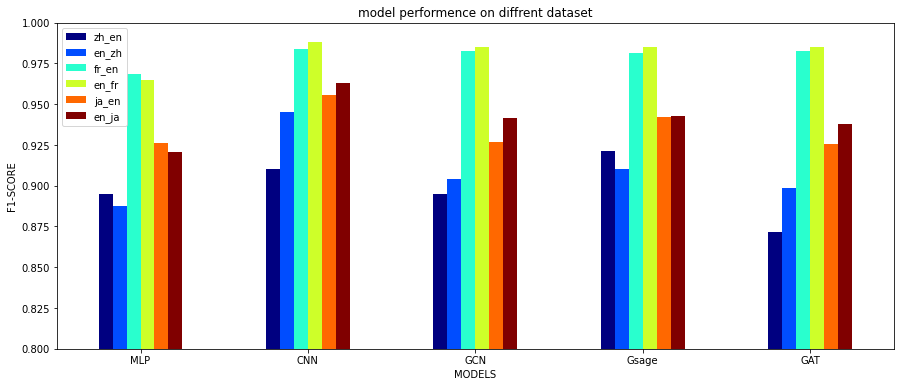

In [ ]:
ax = df.plot.bar(figsize= [15,6], ylim = [0.8,1],rot =0,colormap= 'jet',title = 'model performence on diffrent dataset')
ax.set_xlabel('MODELS')
ax.set_ylabel('F1-SCORE')

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5250 samples in 0.005s...
[t-SNE] Computed neighbors for 5250 samples in 0.143s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5250
[t-SNE] Computed conditional probabilities for sample 2000 / 5250
[t-SNE] Computed conditional probabilities for sample 3000 / 5250
[t-SNE] Computed conditional probabilities for sample 4000 / 5250
[t-SNE] Computed conditional probabilities for sample 5000 / 5250
[t-SNE] Computed conditional probabilities for sample 5250 / 5250
[t-SNE] Mean sigma: 1.004055
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.729446
[t-SNE] KL divergence after 1000 iterations: 0.627038
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5250 samples in 0.005s...
[t-SNE] Computed neighbors for 5250 samples in 0.155s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5250
[t-SNE] Computed conditional probabilities for sample 2000 / 5250
[t-SNE] Computed conditional 

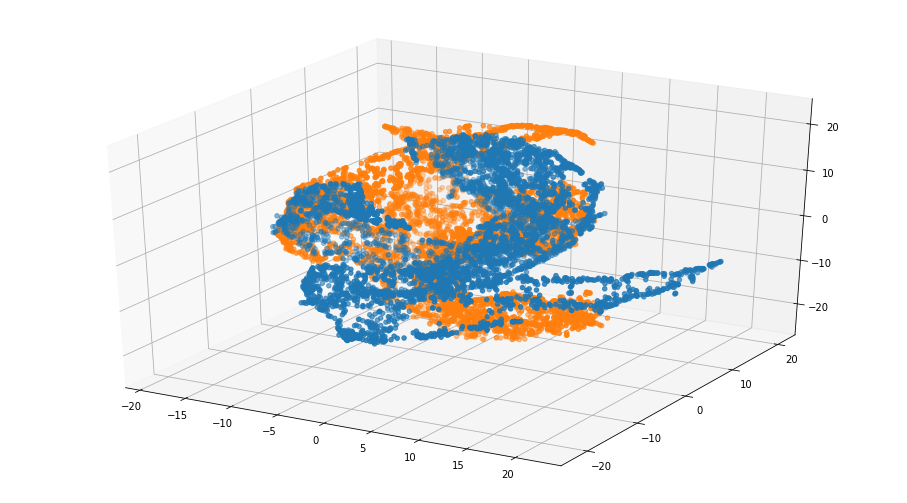

In [ ]:
# from sklearn.metrics import roc_auc_score, f1_score,accuracy_score
# #model = GCN()
# model = Gsage()
# #def train(data , model, 20):
# criterion= torch.nn.BCEWithLogitsLoss()
# #train(data, model1, model2):
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
# best_test_acc=0

# #truth values:
# l=data.train_y[0].tolist()
# #print(len(l))
# one = torch.zeros(l[-1]+1)
# #print(one.shape)
# for i in range(len(l)):
#   if (i> len(l) -1):
#     break
#   one[l[i]] = 1
# print(one.shape) 
# end_train = l[-1]+1
# k=data.test_y[0].tolist()
# #print(sorted(k))
# #print(k[8777])
# k = sorted(k)
# #print(len(sorted(k)))
# truth_y = torch.zeros(k[-1]+1)
# #print(truth_y.shape)
# for i in range(len(k)):
#   # if (i> len(k) -1):
#   #   break
#   truth_y[k[i]] = 1
# #truth_y= truth_y[4500:]  
# #print(truth_y)
# m= k[-1] - l[-1]
# #print('m',m)
# start_val = l[-1]+1 
# end_val = int(m*0.5-1)+4500
# #print('end_val',end_val)
# start_test = end_val+1
# end_test = k[-1]+1
# #print(start_val)
# truth_val_y = truth_y[start_val:end_val] 
# truth_test_y = truth_y[start_test:end_test]
# print('truth_val_y',truth_val_y.shape)
# print('truth_test_y',truth_test_y.shape)
# print('start_val',start_val)
# print('end_val',end_val)
# print('start_test',start_test)
# print('end_test',end_test)
# for e in range(20):
#   #dataset 
#   # train_loader = DataLoader(dataset, batch_size=32, shuffle=True)
#   # for batch in train_loader
    
#   out1 = model(data.x1, data.edge_index1)
#   #print('out1:',out1.shape)
#   out2 = model(data.x2, data.edge_index2)
#   #print('out2:',out2.shape)
#   #pdist = torch.nn.PairwiseDistance(p=2)
#   pdist = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
#   output = pdist(out1[:end_train], out2[:end_train])
#   #print('output:', output.shape)
#   #output = F.sigmoid(output)
#   loss = criterion(output , one)
#   optimizer.zero_grad()
#   loss.backward()
#   optimizer.step()
  
  


#   #train accuracy calculation
#   train_output= output
#   train_output[train_output>0]= 1
#   train_output[train_output<0]= 0
#   train_accuracy = accuracy_score(one.detach().numpy(),train_output.detach().numpy())
#   val_output = pdist(out1[start_val:end_val], out2[start_val:end_val]) 
#   val_output[val_output>0]= 1
#   val_output[val_output<0]= 0
#   val_accuracy = accuracy_score(truth_val_y.detach().numpy(),val_output.detach().numpy())
#   #print("accuracy",accuracy)
#   if e % 5 == 0:
#     print('In epoch {}, loss: {},  train_accuracy: {}, val_accuracy: {}'.format(e, loss,train_accuracy,val_accuracy ))

# print("-"*50)
# #test accuracy, auc, f1 score calculation
# pdist = torch.nn.CosineSimilarity(dim=1, eps=1e-6)

# test_output = pdist(out1[start_test:end_test], out2[start_test:end_test]) 
# auc_score = roc_auc_score(truth_test_y.detach().numpy(),test_output.detach().numpy())
# print("test_auc_score",auc_score)
# test_output[test_output>0]= 1
# test_output[test_output<0]= 0
# accuracy = accuracy_score(truth_test_y.detach().numpy(),test_output.detach().numpy())
# print("test_accuracy",accuracy)
# f1_score_value = f1_score(truth_test_y.detach().numpy(),test_output.detach().numpy())
# print("test_f1_score",f1_score_value)

from sklearn.manifold import TSNE 
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

tsne = TSNE(3, verbose=1)
tsne_proj1 = tsne.fit_transform(out1[start_test:end_test].detach().numpy())
tsne_proj2 = tsne.fit_transform(out2[start_test:end_test].detach().numpy())
# Plot those points as a scatter plot and label them based on the pred labels
#cmap = cm.get_cmap('tab20')
fig = plt.figure(figsize = (16, 9))
ax = plt.axes(projection ="3d")
# num_categories = 10
# for lab in range(num_categories):
#     indices = test_predictions==lab
#     ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], c=np.array(cmap(lab)).reshape(1,4), label = lab ,alpha=0.5)
ax.scatter3D(tsne_proj1[:,0],tsne_proj1[:,1],tsne_proj1[:,2])
ax.scatter3D(tsne_proj2[:,0],tsne_proj2[:,1],tsne_proj2[:,2])
#ax.legend(fontsize='large', markerscale=2)
plt.show()

# EXtras

In [ ]:
# class BatchPairwiseDistance(torch.nn.Module):
#     def __init__(self, p=2., eps=1e-6, keepdim=False):
#             super(BatchPairwiseDistance, self).__init__()
#             self.norm = p
#             self.eps = eps
#             self.keepdim = keepdim

        
#     def forward(self, x1, x2):
#             results = torch.cat((x1[:, 0, :].unsqueeze(1) - x2, x2[:, 0, :].unsqueeze(1) - x1[:, 1:, :]), 1)
#             return results.norm(p=self.norm, dim=2)

In [ ]:
class RGCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        features_dim = data.x1.shape[1]
        # if boll = True:
        #   rel = data.rel1.shape[0]
        # else:
        #   rel = data.rel2.shape[0] 
        rela1 = data.rel1.shape[0] 
        self.conv1 = RGCNConv(features_dim, 150,rela1)
        self.conv2 = RGCNConv(150, 7, rela1)  # 7 is our D here feature vector dimention
        rela2 = data.rel2.shape[0] 
        self.conv3 = RGCNConv(features_dim, 150,rela2)
        self.conv4 = RGCNConv(150, 7, rela2)
        #self.linear = torch.nn.Linear(7,1)

    def forward(self, featss,index,rel_matrix,bool):
        
        x, edge_index,edge_type = featss, index, rel_matrix 
        if bool == 'Graph1':

          x = self.conv1(x, edge_index,edge_type)
          x = F.relu(x)
          x = self.conv2(x, edge_index, edge_type)
        elif bool == 'Graph2':
          x = self.conv3(x, edge_index,edge_type)
          x = F.relu(x)
          x = self.conv4(x, edge_index, edge_type)

        # x = F.relu(x)
        # x = self.Linear(x)
        # x = F.relu(x)

        return x


In [ ]:
from sklearn.metrics import roc_auc_score, f1_score,accuracy_score
#model = GCN()
#model = Gsage()
#def train(data , model):
model = RGCN().to(device)
criterion= torch.nn.BCEWithLogitsLoss()
#train(data, model1, model2):
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
best_test_acc=0
for e in range(70):
  #dataset 
  # train_loader = DataLoader(dataset, batch_size=32, shuffle=True)
  # for batch in train_loader
  data = data.to(device)  
  out1 = model(data.x1, data.edge_index1, data.rel1, 'Graph1')
  #print('out1:',out1.shape)
  out2 = model(data.x2, data.edge_index2, data.rel2, 'Graph2')
  #print('out2:',out2.shape)
  #pdist = torch.nn.PairwiseDistance(p=2)
  pdist = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
  output = pdist(out1[:4500], out2[:4500])
  #print('output:', output)
  #output = F.sigmoid(output)
  loss = criterion(output , one)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  
  


  #train accuracy calculation
  train_output= output
  train_output[train_output>0]= 1
  train_output[train_output<0]= 0
  train_accuracy = accuracy_score(one.detach().numpy(),train_output.detach().numpy())
  #print("accuracy",accuracy)
  if e % 5 == 0:
    print('In epoch {}, loss: {},  train_accuracy: {}'.format(e, loss,train_accuracy ))

print("-"*50)
#test accuracy, auc, f1 score calculation
pdist = torch.nn.CosineSimilarity(dim=1, eps=1e-6)

test_output = pdist(out1[4500:15000], out2[4500:15000]) 
auc_score = roc_auc_score(truth_y.detach().numpy(),test_output.detach().numpy())
print("test_auc_score",auc_score)
test_output[test_output>0]= 1
test_output[test_output<0]= 0
accuracy = accuracy_score(truth_y.detach().numpy(),test_output.detach().numpy())
print("test_accuracy",accuracy)
f1_score_value = f1_score(truth_y.detach().numpy(),test_output.detach().numpy())
print("test_f1_score",f1_score_value)

In [ ]:
# pdist = torch.nn.PairwiseDistance(p=2)
# input1 = torch.randn(100, 128)
# input2 = torch.randn(100, 128)
# output = pdist(input1, input2)
# F.sigmoid(output)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000])

In [ ]:
data = DBP15K('/content/dd', 'zh_en', transform=SumEmbedding())[0]
data

Data(edge_index1=[2, 70414], edge_index2=[2, 95142], rel1=[70414], rel2=[95142], test_y=[2, 8778], train_y=[2, 3205], x1=[19388, 300], x2=[19572, 300])

In [ ]:
data2 = DBP15K('/content/dd', 'ja_en', transform=SumEmbedding())[0]
data2

Data(edge_index1=[2, 77214], edge_index2=[2, 93484], rel1=[77214], rel2=[93484], test_y=[2, 9282], train_y=[2, 3452], x1=[19814, 300], x2=[19780, 300])

In [ ]:
data1 = DBP15K('/content/dd', 'en_zh', transform=SumEmbedding())[0]
data1

Data(edge_index1=[2, 95142], edge_index2=[2, 70414], rel1=[95142], rel2=[70414], test_y=[2, 9146], train_y=[2, 3243], x1=[19572, 300], x2=[19388, 300])

In [ ]:
data3 = DBP15K('/content/dd', 'en_fr', transform=SumEmbedding())[0]
data3

Processing...
Done!


Data(edge_index1=[2, 115722], edge_index2=[2, 105998], rel1=[115722], rel2=[105998], test_y=[2, 10181], train_y=[2, 4096], x1=[19993, 300], x2=[19661, 300])

In [ ]:
data3.rel1

In [ ]:
from torch_geometric.data import Data

In [ ]:
data_en_from_ja= Data(x=data2.x2, edge_index=data2.edge_index2)
data_en_from_ja

Data(edge_index=[2, 93484], x=[19780, 300])

In [ ]:
data_en_from_zh= Data(x=data1.x1, edge_index=data1.edge_index1)
data_en_from_zh

Data(edge_index=[2, 95142], x=[19572, 300])

In [ ]:
import networkx as nx
import numpy as np


In [ ]:
def to_networkx(data, node_attrs=None, edge_attrs=None, to_undirected=False,
                remove_self_loops=False):
    r"""Converts a :class:`torch_geometric.data.Data` instance to a
    :obj:`networkx.Graph` if :attr:`to_undirected` is set to :obj:`True`, or
    a directed :obj:`networkx.DiGraph` otherwise.

    Args:
        data (torch_geometric.data.Data): The data object.
        node_attrs (iterable of str, optional): The node attributes to be
            copied. (default: :obj:`None`)
        edge_attrs (iterable of str, optional): The edge attributes to be
            copied. (default: :obj:`None`)
        to_undirected (bool, optional): If set to :obj:`True`, will return a
            a :obj:`networkx.Graph` instead of a :obj:`networkx.DiGraph`. The
            undirected graph will correspond to the upper triangle of the
            corresponding adjacency matrix. (default: :obj:`False`)
        remove_self_loops (bool, optional): If set to :obj:`True`, will not
            include self loops in the resulting graph. (default: :obj:`False`)
    """

    if to_undirected:
        G = nx.Graph()
    else:
        G = nx.DiGraph()

    G.add_nodes_from(range(data.num_nodes))

    values = {}
    for key, item in data:
        if torch.is_tensor(item):
            values[key] = item.squeeze().tolist()
        else:
            values[key] = item
        if isinstance(values[key], (list, tuple)) and len(values[key]) == 1:
            values[key] = item[0]
    print(values[key][0])
    print(type(values[key][0]))
    t = np.array(values[key][0])
    print(t)
    for i, (u, v) in enumerate(data.edge_index.t().tolist()):

        if to_undirected and v > u:
            continue

        if remove_self_loops and u == v:
            continue

        G.add_edge(u, v)
        for key in edge_attrs if edge_attrs is not None else []:
            G[u][v][key] = values[key][i]
    print('g.nodes',G.nodes(data=True))
    for key in node_attrs if node_attrs is not None else []:
        print('key----------------',key)
        for i, feat_dict in G.nodes(data=True):
            # print(i)
            # print(feat_dict)
            # print('key',np.array(key[i]))
            # print('value key ', values[key][i])
            # print('tensor values ',torch.tensor(np.array(values[key][i])))
            feat_dict.update({i:[key][i]})
            print('after feats_dict',feat_dict)
            
            # print('after feats_dict',feat_dict)
            #feat_dict.update({key: values[key][i]})
            break;
            exit()
        exit()    
    exit()
    return G
#print(data_en_from_zh.x)
f=np.array(data_en_from_zh.x)
#print(f)
g1 =to_networkx(data_en_from_zh, node_attrs=[data_en_from_zh.x], edge_attrs=None, to_undirected=False,remove_self_loops=False)
                

g1

[-0.0331450030207634, -0.8536990284919739, 0.7675899863243103, -0.5427900552749634, 0.36875998973846436, 0.6701589822769165, -0.24517002701759338, 0.4249500036239624, -0.2785300016403198, 0.5414499640464783, 0.3231230080127716, 0.8096700310707092, 0.4463309943675995, -0.10429999977350235, 0.8368399739265442, 0.15958000719547272, 0.6390500068664551, -1.368340015411377, -0.16150200366973877, 0.14365901052951813, 1.0005600452423096, -0.3690800070762634, 0.9497299790382385, 0.3955399990081787, 0.39496999979019165, -0.2194400131702423, 0.03534999489784241, -0.3515460193157196, 0.4458700120449066, 0.7483800053596497, -0.572409987449646, 0.3138200044631958, 1.231260061264038, 0.1979070007801056, -0.12512001395225525, -0.27781999111175537, 0.2061299979686737, -0.05220998823642731, 0.9062299728393555, -0.0888030007481575, 0.7858799695968628, 0.09435799717903137, -0.04313400387763977, -0.5912319421768188, -0.49592000246047974, -0.38922297954559326, 0.5378699898719788, 0.6427379846572876, -0.0941

In [ ]:
np.array(values[key][i])

NameError: ignored

In [ ]:
g1 =to_networkx(data_en_from_zh, node_attrs=data_en_from_zh.x, edge_attrs=None, to_undirected=False,
                remove_self_loops=True)

g1

In [ ]:
g2 =to_networkx(data_en_from_ja, node_attrs=data_en_from_ja.x, edge_attrs=None, to_undirected=False,
                remove_self_loops=True)

g2